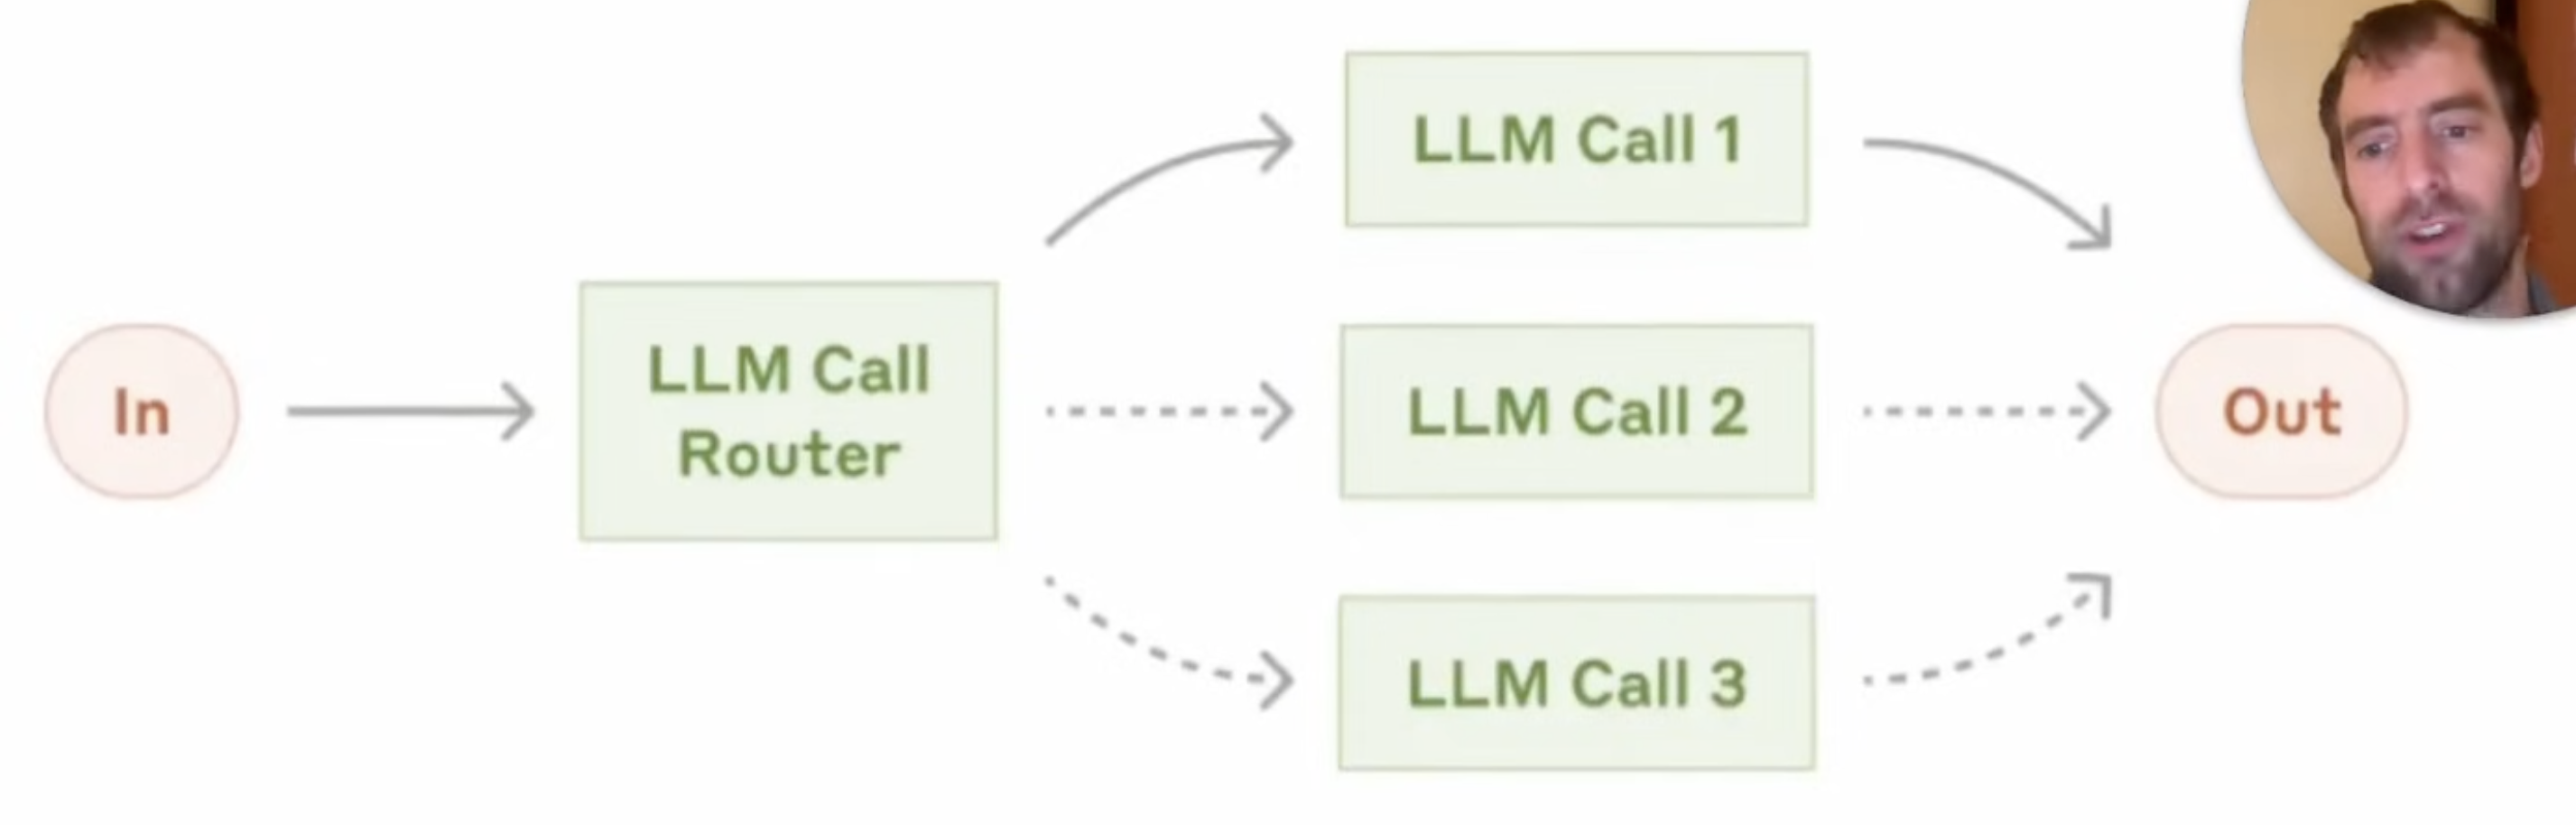

Routing classifies an input and directs it to a specialized followup task
- e.g.,when routing a question to different retrieval systems.

Example:
- Route an input between joke,story,and poem


In [1]:
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from IPython.display import Image,display
import os

llm = ChatOpenAI(
    model_name="qwen-turbo-latest",
    base_url=os.getenv("LLM_BASE_URL"),
    api_key=os.getenv("LLM_API_KEY")
)

/Users/daijunjie/miniconda3/envs/langchain-env/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
from typing import Literal

from pydantic import BaseModel, Field


class Route(BaseModel):
    step:Literal["poem","joke","story"] = Field(
        None,
        description="The next step in routing process",
    )

# Augment the LLM with schema for structured output    
router = llm.with_structured_output(Route)

In [12]:
class State(TypedDict):
    input:str
    decision:str
    output:str

from langchain_core.messages import HumanMessage,SystemMessage
def llm_call_1(state:State):
    """write a story"""
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state:State):
    """write a poem"""
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state:State):
    """write a joke"""
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state:State):
    """route the input to the appropriate node,(poem,joke,story)"""
    # Run the augmented LLM with structured output to serve as a routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content=f"Route the input to story,joke or poem based on the user's request.return output in json:{{'step':'poem' \\joke or story}}"
            ),
            HumanMessage(content=state["input"])
        ]
    )
    print(f'router decision: {decision}')
    return {"decision": decision.step}
    
# Conditional edge function
def route_decision(state:State):
    """Decide the next step based on the decision made by the router"""
    return state["decision"]

graph = StateGraph(State)
graph.add_node("router",llm_call_router)
graph.add_node("story", llm_call_1)
graph.add_node("poem", llm_call_2)
graph.add_node("joke", llm_call_3)

graph.add_edge(START, "router")
# 这几个不加也会自动到end
graph.add_edge("story", END)
graph.add_edge("poem", END)
graph.add_edge("joke", END)
# 条件边 用来路由
graph.add_conditional_edges(
    "router",
    route_decision,
    {
        "story": "story",
        "poem": "poem",
        "joke": "joke"
    }
)

agent = graph.compile()


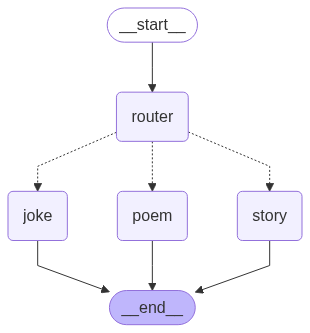

In [4]:
# 可视化agent
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))


In [14]:
for event in agent.stream(
    {"input":"tell me a joke about 黄仁勋"}
):
    print(event)

router decision: step='joke'
{'router': {'decision': 'joke'}}
{'joke': {'output': '当然！这是一个关于黄仁勋（Jensen Huang）的幽默小笑话：\n\n为什么黄仁勋从来不玩扑克牌？  \n因为他一看到底牌就忍不住说：“这卡是NVIDIA的，我得优化一下！” 😄\n\n（注：这是基于他作为英伟达CEO对AI和GPU技术的热爱编的玩笑，纯属娱乐～）'}}
